## Setup

In [1]:
#pip install pynamics

In [2]:
%matplotlib inline
import scipy.optimize
import pynamics
from pynamics.frame import Frame
from pynamics.variable_types import Differentiable,Constant
from pynamics.system import System
from pynamics.body import Body
from pynamics.dyadic import Dyadic
from pynamics.output import Output,PointsOutput
from pynamics.particle import Particle
import pynamics.integration
import numpy
import sympy
import matplotlib.pyplot as plt
from matplotlib.patches import Arc
plt.ion()
from math import pi, sin, cos, tan, asin, acos, atan, degrees, radians, pi, sqrt

## System

In [3]:
# Create a pynamics system
system = System()
pynamics.set_system(__name__,system)

In [4]:
# Length variables (numerical)
lAa_num = 0.05
lAb_num = 0.1
lBa_num = 0.05
lBb_num = 0.1
lC_num = 0.165
lD_num = 0.165
lE_num = 0.045

# Lengths
lAa = Constant(lAa_num,'lAa',system)
lAb = Constant(lAb_num,'lAb',system)
lBa = Constant(lBa_num,'lBa',system)
lBb = Constant(lBb_num,'lBb',system)
lC = Constant(lC_num,'lC',system)
lD = Constant(lD_num,'lD',system)
lE = Constant(lE_num,'lE',system)

In [5]:
# Masses
# r = 149kg/m3
mAa = Constant(0.00447,'mAa',system) # 0.00447000 
mAb = Constant(0.00894,'mAb',system) # 0.00894000 
mBa = Constant(0.00626,'mBa',system) # 0.00625800
mBb = Constant(0.00894,'mBb',system) # 0.00894000 
mC = Constant(0.0148,'mC',system) # 0.01475100
mD = Constant(0.0148,'mD',system) # 0.01475100

# Joint preloads
preload0 = Constant(0*pi/180,'preload0',system)
preloadA = Constant(0*pi/180,'preloadA',system)
preload1 = Constant(0*pi/180,'preload1',system)
preloadB = Constant(0*pi/180,'preloadB',system)
preload4 = Constant(0*pi/180,'preload4',system)
preload3 = Constant(0*pi/180,'preload3',system)

# Inertia
Ixx_Aa = Constant(0.0000336,'Ixx_Aa',system) # 0.00003355
Iyy_Aa = Constant(0.0000373,'Iyy_Aa',system) # 0.00003725
Izz_Aa = Constant(0.0000038,'Izz_Aa',system) # 0.00000375
Ixx_Ab = Constant(0.0000671,'Ixx_Ab',system) # 0.00006710
Iyy_Ab = Constant(0.0000969,'Iyy_Ab',system) # 0.00009685
Izz_Ab = Constant(0.0000299,'Izz_Ab',system) # 0.00002985

Ixx_Ba = Constant(0.0000441,'Ixx_Ba',system) # 0.00004405
Iyy_Ba = Constant(0.0000484,'Iyy_Ba',system) # 0.00004840
Izz_Ba = Constant(0.0000045,'Izz_Ba',system) # 0.00000453
Ixx_Bb = Constant(0.0000671,'Ixx_Bb',system) # 0.00006710
Iyy_Bb = Constant(0.0000969,'Iyy_Bb',system) # 0.00009685
Izz_Bb = Constant(0.0000299,'Izz_Bb',system) # 0.00002985

Ixx_C = Constant(0.0001107,'Ixx_C',system) # 0.00011071
Iyy_C = Constant(0.0002445,'Iyy_C',system) # 0.00024450
Izz_C = Constant(0.000134,'Izz_C',system) # 0.00013394

Ixx_D = Constant(0.0001107,'Ixx_D',system) # 0.00011071
Iyy_D = Constant(0.0002445,'Iyy_D',system) # 0.00024450
Izz_D = Constant(0.0001339,'Izz_D',system) # 0.00013394

In [6]:
# Create differentiable state variables
qAa,qAa_d,qAa_dd = Differentiable('qAa',system)
qAb,qAb_d,qAb_dd = Differentiable('qAb',system)

qBa,qBa_d,qBa_dd = Differentiable('qBa',system)
qBb,qBb_d,qBb_dd = Differentiable('qBb',system)

qC,qC_d,qC_dd = Differentiable('qC',system)

qD,qD_d,qD_dd = Differentiable('qD',system)

In [7]:
# initial values
# qC = 11.97 creates fully extended, horizontal wing
initialvalues = {}
initialvalues[qAa]=45*pi/180
initialvalues[qAa_d]=0*pi/180
initialvalues[qAb]=0*pi/180
initialvalues[qAb_d]=0*pi/180

initialvalues[qBa]=0*pi/180
initialvalues[qBa_d]=0*pi/180
initialvalues[qBb]=0*pi/180
initialvalues[qBb_d]=0*pi/180

#initialvalues[qC]=14.65*pi/180
initialvalues[qC]=(90-16.69)*pi/180
initialvalues[qC_d]=0*pi/180

initialvalues[qD]=-70.16*pi/180
initialvalues[qD_d]=0*pi/180

In [8]:
# Retrieve state variables in the order they are stored in the system
# Create a list of initial values ini0 in the order of the system’s state variables
statevariables = system.get_state_variables()
ini0 = [initialvalues[item] for item in statevariables]

In [9]:
# Create frames
N = Frame('N')
Aa = Frame('Aa')
Ab = Frame('Ab')

Ba = Frame('Ba')
Bb = Frame('Bb')

C = Frame('C')
D = Frame('D')

In [10]:
# Declare N as the Newtonian (fixed) frame
system.set_newtonian(N)

In [11]:
# Rotate other frames about their local Z axes.
# Not global q
Aa.rotate_fixed_axis_directed(N,[0,0,1],qAa,system)
Ab.rotate_fixed_axis_directed(Aa,[0,0,1],qAb,system)

Ba.rotate_fixed_axis_directed(Ab,[0,0,1],qBa,system)
Bb.rotate_fixed_axis_directed(Ba,[0,0,1],qBb,system)

C.rotate_fixed_axis_directed(Bb,[0,0,1],qC,system)
D.rotate_fixed_axis_directed(C,[0,0,1],qD,system)

In [12]:
# Define rigid body kinematics
# position vectors
p0 = 0*N.x #Normal
pA = p0 + lAa*Aa.x #Normal
p1 = pA + lAb*Ab.x #Link A
pB = p1 + lBa*Ba.x #Link A
p2A = pB + lBb*Bb.x #Link B - OUTPUT
p4 = p0 + lE*N.y #Link E
p3 = p4 + lC*C.x #Link C
p2C = p3 + lD*D.x #Link D - OUTPUT

In [13]:
# CoM vectors
pAacom=p0 + lAa/2*Aa.x #Link Aa
pAbcom=pA + lAb/2*Ab.x #Link Ab

pBacom=p1 + 0.0207*Ba.x + 0.00314*Ba.y #Link Ba # 0.02071429x 0.00314286y
pBbcom=pB + lBb*Bb.x #Link Bb

pCcom=p4 + lC/2*C.x #Link Ca
pDcom=p3 + lD/2*D.x #Link Da

In [14]:
# Angular Velocity
wNAa = N.getw_(Aa)
wAaAb = Aa.getw_(Ab)

wAbBa = Ab.getw_(Ba)
wBaBb = Ba.getw_(Bb)

wNC = N.getw_(C)
wCD = C.getw_(D)

In [15]:
# Build inertia tensors
IAa = Dyadic.build(Aa,Ixx_Aa,Iyy_Aa,Izz_Aa)
IAb = Dyadic.build(Ab,Ixx_Ab,Iyy_Ab,Izz_Ab)

IBa = Dyadic.build(Ba,Ixx_Ba,Iyy_Ba,Izz_Ba)
IBb = Dyadic.build(Bb,Ixx_Bb,Iyy_Bb,Izz_Bb)

IC = Dyadic.build(C,Ixx_C,Iyy_C,Izz_C)
ID = Dyadic.build(D,Ixx_D,Iyy_D,Izz_D)

BodyAa = Body('BodyAa',Aa,pAacom,mAa,IAa,system)
BodyAb = Body('BodyAb',Ab,pAbcom,mAb,IAb,system)

BodyBa = Body('BodyBa',Ba,pBacom,mBa,IBa,system)
BodyBb = Body('BodyBb',Bb,pBbcom,mBb,IBb,system)

BodyC = Body('BodyC',C,pCcom,mC,IC,system)
BodyD = Body('BodyD',D,pDcom,mD,ID,system)
#BodyC = Particle(pCcm,mC,'ParticleC',system)

## Forces

In [16]:
# Spring Forces
kbase = Constant(1e-4,'kbase',system)
kjoint = Constant(1e-3,'kjoint',system)
kbend = Constant(6,'kbend',system)
klim = Constant(3,'klim',system)

dK = kbase-klim

In [17]:
system.add_spring_force1(kbase,(qAa-preload0)*N.z,wNAa) # qA
system.add_spring_force1(kbend,(qAb-preloadA)*Aa.z,wAaAb)  # virtual A

#system.add_spring_force1(dK*on+klim,(qBa-preload1)*Ab.z,wAbBa) # Limiter
system.add_spring_force1(kbase,(qBa-preload1)*Ab.z,wAbBa) # Limiter Torque off

system.add_spring_force1(kbend,(qBb-preloadB)*Ba.z,wBaBb) # virtual B

system.add_spring_force1(kbase,(qC-preload4)*N.z,wNC) # qC
system.add_spring_force1(kjoint,(qD-preload3)*C.z,wCD) # qD

(<pynamics.force.Force at 0x1a44a573070>,
 <pynamics.spring.Spring at 0x1a44a573b50>)

In [18]:
# Damping
bbase = Constant(1e-2,'b',system)
bjoint = Constant(1e-2,'b',system)

In [19]:
system.addforce(-bbase*wNAa,wNAa) # qA
system.addforce(-bjoint*wAbBa,wAbBa) # qB
system.addforce(-bbase*wNC,wNC) # qC
system.addforce(-bjoint*wCD,wCD) # qD

In [20]:
# Aerodynamic Forces
rho = Constant(1.225,'rho',system) # air density
w = Constant(0.15,'w',system) # width or chord length

In [21]:
vAacom= pAacom.time_derivative(N,system)
vAacom2= pAacom.dot(vAacom)
vAbcom= pAbcom.time_derivative(N,system)
vAbcom2= pAbcom.dot(vAbcom)

vBacom= pBacom.time_derivative(N,system)
vBacom2= pBacom.dot(vBacom)
vBbcom= pBbcom.time_derivative(N,system)
vBbcom2= pBbcom.dot(vBbcom)

vCcom= pCcom.time_derivative(N,system)
vCcom2= pCcom.dot(vCcom)
vDcom= pDcom.time_derivative(N,system)
vDcom2= pDcom.dot(vDcom)

In [22]:
vAadx = vAacom.dot(Aa.x)
vAbdx = vAbcom.dot(Ab.x)
vBadx = vBacom.dot(Ba.x)
vBbdx = vBbcom.dot(Bb.x)
vCdx = vCcom.dot(C.x)
vDdx = vDcom.dot(D.x)

vAady = vAacom.dot(-Aa.y)
vAbdy = vAbcom.dot(-Ab.y)
vBady = vBacom.dot(-Ba.y)
vBbdy = vBbcom.dot(-Bb.y)
vCdy = vCcom.dot(-C.y)
vDdy = vDcom.dot(-D.y)

In [23]:
tolv = 1e-10

In [24]:
aoa_Aa = sympy.atan2(vAady+tolv,vAadx)
aoa_Ab = sympy.atan2(vAbdy+tolv,vAbdx)
aoa_Ba = sympy.atan2(vBady+tolv,vBadx)
aoa_Bb = sympy.atan2(vBbdy+tolv,vBbdx)
aoa_C = sympy.atan2(vCdy+tolv,vCdx)
aoa_D = sympy.atan2(vDdy+tolv,vDdx)

In [25]:
aero_Aa = rho*vAacom2*sympy.sin(aoa_Aa)*w*lAa*Aa.y
system.addforce(aero_Aa,vAacom)

aero_Ab = rho*vAbcom2*sympy.sin(aoa_Ab)*w*lAb*Ab.y
system.addforce(aero_Ab,vAbcom)

aero_Ba = rho*vBacom2*sympy.sin(aoa_Ba)*w*lBa*Ba.y
system.addforce(aero_Ba,vBacom)

aero_Bb = rho*vBbcom2*sympy.sin(aoa_Bb)*w*lBb*Bb.y
system.addforce(aero_Bb,vBbcom)

aero_C = rho*vCcom2*sympy.sin(aoa_C)*w*lC*C.y
system.addforce(aero_C,vCcom)

aero_D = rho*vDcom2*sympy.sin(aoa_D)*w*lD*D.y
system.addforce(aero_D,vDcom)

In [26]:
# Gravity
g = Constant(9.81,'g',system)
system.addforcegravity(-g*N.y)

## Constraints

In [27]:
# ptipup = 0.547*N.x+0.547*N.y

In [28]:
# Constraints
eq_vector = p2A-p2C
eq = []
eq.append((eq_vector).dot(N.x))
eq.append((eq_vector).dot(N.y))
eq_d=[(system.derivative(item)) for item in eq]
eq_dd=[(system.derivative(item)) for item in eq_d]

eq2_vector = Ab.x-Ba.x
eq2 = []
eq2.append((eq2_vector).dot(N.x))
eq2.append((eq2_vector).dot(N.y))
eq2_d=[(system.derivative(item)) for item in eq2]
eq2_dd=[(system.derivative(item)) for item in eq2_d]

## Solve for valid initial condition

In [29]:
# Declare a list of points that will be used for plotting
points = [p0, pA, p1, pB, p2A, p3, p4]

In [30]:
# Identify independent and dependent variables
qi = [qAa, qC]
qd = [qAb, qBa, qBb, qD]

In [31]:
# Create a copy of symbolic constants dictionary and add the initial value of qi to it
constants = system.constant_values.copy()
defined = dict([(item,initialvalues[item]) for item in qi])
constants.update(defined)

In [32]:
# Substitute constants in equation
eq = [item.subs(constants) for item in eq]
eq2 = [item.subs(constants) for item in eq2]

In [33]:
# Convert to numpy array
# Sum the error
error = (numpy.array(eq)**2).sum() + (numpy.array(eq2)**2).sum()

In [34]:
# Convert to a function that scipy can use.
# Sympy has a “labmdify” function that evaluates an expression, but scipy needs a slightly different format.
f = sympy.lambdify(qd,error)

def function(args):
    return f(*args)

In [35]:
# Take the derivative of the equations to linearize with regard to the velocity variables
guess = [initialvalues[item] for item in qd]
result = scipy.optimize.minimize(function,guess)
if result.fun>1e-3:
    raise(Exception("out of tolerance"))
ini = []
for item in system.get_state_variables():
    if item in qd:
        ini.append(result.x[qd.index(item)])
    else:
        ini.append(initialvalues[item])
points = PointsOutput(points, constant_values=system.constant_values)
points.calc(numpy.array([ini0,ini]))
#points.plot_time()

2021-03-19 22:09:49,105 - pynamics.output - INFO - calculating outputs
2021-03-19 22:09:49,107 - pynamics.output - INFO - done calculating outputs


array([[[ 0.        ,  0.        ],
        [ 0.03535534,  0.03535534],
        [ 0.10606602,  0.10606602],
        [ 0.14142136,  0.14142136],
        [ 0.21213203,  0.21213203],
        [-0.07824991,  0.19026511],
        [ 0.        ,  0.045     ]],

       [[ 0.        ,  0.        ],
        [ 0.03535534,  0.03535534],
        [ 0.10369392,  0.10836109],
        [ 0.13786317,  0.14486399],
        [ 0.23496063,  0.12094575],
        [ 0.08381403,  0.18712744],
        [ 0.        ,  0.045     ]]])

In [36]:
result.fun

2.0881017314179564e-12

In [37]:
# Valid initial condition
x = numpy.array([points.y[1][0][0], points.y[1][1][0], points.y[1][2][0], points.y[1][3][0], points.y[1][4][0], points.y[1][5][0], points.y[1][6][0], 0])
y = numpy.array([points.y[1][0][1], points.y[1][1][1], points.y[1][2][1], points.y[1][3][1], points.y[1][4][1], points.y[1][5][1], points.y[1][6][1], 0])
# prettyplot(x,y)

## Solution

In [38]:
# F=ma
f,ma = system.getdynamics()

2021-03-19 22:09:49,144 - pynamics.system - INFO - getting dynamic equations


In [39]:
# Acceleration
func1,lambda1 = system.state_space_post_invert(f,ma,eq_dd,return_lambda = True)

2021-03-19 22:09:49,909 - pynamics.system - INFO - solving a = f/m and creating function
2021-03-19 22:09:49,918 - pynamics.system - INFO - substituting constrained in Ma-f.
2021-03-19 22:09:56,174 - pynamics.system - INFO - done solving a = f/m and creating function
2021-03-19 22:09:56,175 - pynamics.system - INFO - calculating function for lambdas


In [40]:
# Integration Tolerance
tol = 1e-6

In [41]:
# Time
tinitial = 0
#tfinal = 1
tfinal = 4 # torque off
fps = 30
tstep = 1/fps
t = numpy.r_[tinitial:tfinal:tstep]

In [42]:
# Integrate
states=pynamics.integration.integrate(func1,ini,t,rtol=tol,atol=tol, args=({'constants':system.constant_values},))

2021-03-19 22:09:56,223 - pynamics.integration - INFO - beginning integration
2021-03-19 22:09:56,224 - pynamics.system - INFO - integration at time 0000.00
2021-03-19 22:10:09,420 - pynamics.system - INFO - integration at time 0000.08
2021-03-19 22:10:23,481 - pynamics.system - INFO - integration at time 0003.91
2021-03-19 22:10:23,508 - pynamics.integration - INFO - finished integration


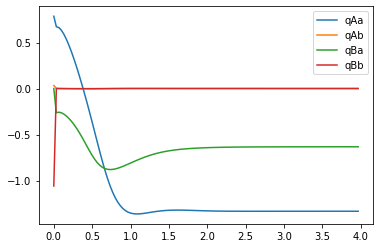

In [43]:
# Outputs
plt.figure()
artists = plt.plot(t,states[:,:4])
plt.legend(artists,['qAa','qAb','qBa','qBb','qC','qD'])

2021-03-19 22:10:23,752 - pynamics.output - INFO - calculating outputs
2021-03-19 22:10:23,775 - pynamics.output - INFO - done calculating outputs


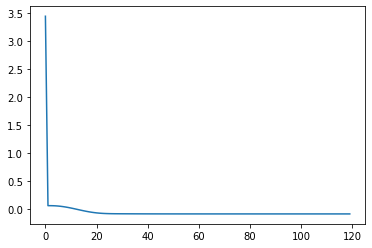

In [44]:
# Energy
KE = system.get_KE()
PE = system.getPEGravity(p0) - system.getPESprings()
energy_output = Output([KE-PE],system)
energy_output.calc(states)
energy_output.plot_time()

2021-03-19 22:10:23,911 - pynamics.output - INFO - calculating outputs
2021-03-19 22:10:23,930 - pynamics.output - INFO - done calculating outputs


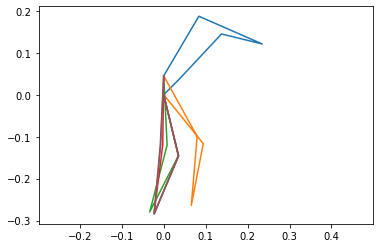

In [45]:
# Motion
points = [p0,pA,p1,pB,p2A,p3,p4]
points_output = PointsOutput(points,system)
y = points_output.calc(states)
points_output.plot_time(20)

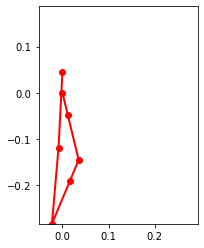

In [46]:
# Motion Animation
points_output.animate(fps = fps,movie_name = 'render.mp4',lw=2,marker='o',color=(1,0,0,1),linestyle='-')

In [47]:
from matplotlib import animation, rc
from IPython.display import HTML
HTML(points_output.anim.to_html5_video())